C-Mapss Turbofan Dataset: Remaining Useful Life Estimation in Prognostics Using Deep Convolution Neural Networks

This script reproduces the implementation of a Deep Convolutional Network  by Xiang Li et al. applied to the NASA "CMAPSS" dataset in Keras. Basic code is taken from Manuel Arias, Christian Schneebeli and Lukas R. Peter 2017.
Gerd Nollmann, Karlsruhe, KIT

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU
from tensorflow.python import keras
from tensorflow.python.keras import layers, initializers
from tensorflow.keras import layers
from tensorflow.keras.layers import multiply, Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, LocallyConnected2D, Concatenate, Masking, Multiply, MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils.conv_utils import convert_kernel
from tensorflow.keras.utils import get_source_inputs
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.initializers import glorot_uniform, he_uniform, TruncatedNormal
from tensorflow.keras import optimizers
from IPython.display import SVG, clear_output
from os import path
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
import tensorflow.keras.callbacks
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import max_norm, MinMaxNorm
from tensorflow.keras.layers import Lambda
from tensorflow.python.keras.backend import expand_dims
import tensorflow.keras.preprocessing.sequence 
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# 1  "CMAPSS" Dataset

The NASA C-MAPSS dataset FD001 provides degradation trajectories of 100 turbofan engines with unknown and different initial health condition. The training data contains multivariate sensors readings of the complete run-to-failure trajectories. The records stop at the cycle/time the engine failed. For the test set truncated time-series of various lengths prior to failure are provided for 100 engines. 


- Training: 17731 inputs from 100 engine trajectories if using a sliding time window of 30 time stamps. 
- Test: 100 points from 100 engine trajectories. Researchers mostly take only the last available 30 time stamps.
- New approach proposed: use max time series of 362 so that test information history is used properly.

The original dataset is usually processed with a sliding time window approach of size $N_f = 30$ and stride of 1. The following script changes the "window" to a max time series of 362. Machines with shorter time series get a 0 padding.

**Time window details**
- $N_{tw} = 362$ 
- Stride = 1

In [3]:
def sliding_window(data, N_tw = 362, stride = 1):
    N_en = np.unique(data[:,0]).shape[0]                            # Number of engines (N_en)
    m = 0
    for i in range(N_en):
        n_H   = data[data[:,0] == i+1,0].shape[0]
        N_sw  = int((n_H- N_tw) / stride + 1)                       # Number of sliding windows for engine 'i' 
        for h in range(N_sw):
            m = m + 1    
    return m, N_en        

In [38]:
def load_dataset(N_tw, stride, sel, R_early):
    # Load training data
    basepath        = path.dirname(os.getcwd()) 
    train_set       = np.loadtxt(path.abspath(path.join(basepath, "data", "FD001train_V2.txt")))  # Training set, right-padded to 362*100
    train_set_x_org = train_set[:,sel]                              # Training set input space (x)    
    train_set_c     = train_set[:,np.array([1])]                    # Training set cycles (c)
    
    # Normalize the data
    ub = train_set_x_org.max(0)
    lb = train_set_x_org.min(0)    
    train_set_x = 2 * (train_set_x_org - lb) / (ub - lb) - 1   
   
    N_ft    = sel.shape[0]                                           # Nunber of features (N_ft)
    m, N_en = sliding_window(train_set, N_tw, stride)                # Number of training data & engines
    
    train_x = np.empty((m, N_tw, N_ft, 1), float)
    train_y = np.empty((m, 1), float)
    
    k = 0
    for i in range(N_en):
        idx       = train_set[:,0] == i+1                            # Index for engine number 'i'
        train_i_x = train_set_x[idx,:]                               # Engine 'i' training  data
        train_i_c = train_set_c[idx]                                 # Engine 'i' cycles (c)
        train_i_y = train_i_c[-1] - train_i_c                        # RUL: Remaining Useful Lifetime for engine 'i'
        train_i_y[train_i_y > R_early] = R_early                     # R_early = 125
        N_sw      = int((train_i_x.shape[0] - N_tw) / stride + 1)    # Number of sliding windows for engine 'i' 
        for h in range(N_sw):
            k = k + 1
            vert_start = h * stride
            vert_end   = h * stride + N_tw
            train_i_x_slice = train_i_x[vert_start:vert_end,:]       # Training input data for engine 'i' on time window 'h'
            train_i_y_slice = train_i_y[vert_end-1,:]                # Training output data for engine 'i' on time window 'h'
            train_i_x_slice.shape = (N_tw, N_ft, 1)                  # Reshape training set input (N_tw, N_ft, 1)
            train_i_y_slice.shape = (1, 1)                           # Reshape training set output (1, 1)
            train_x[k-1,:,:] = train_i_x_slice
            train_y[k-1,:] = train_i_y_slice
     
    # Load test data
    test_set       = np.loadtxt(path.abspath(path.join(basepath, "data", "FD001test_V2.txt"))) #set is right-padded to 362*100
    test_set_x_org = test_set[:,sel]                                 # Test set input space (x)
    test_set_c     = test_set[:,np.array([1])]                       # Test set cycles (c)
    test_y         = np.loadtxt(path.abspath(path.join(basepath, "data", "RUL_FD001.txt")))    # Test set RUL (c)
    test_y.shape   = (test_y.shape[0], 1)
    
    # Normalize the data
    test_set_x = 2 * (test_set_x_org - lb) / (ub - lb) - 1   
    
    m_ts, N_en_ts = sliding_window(test_set, N_tw, stride)           # Number of training data & engines
    
    test_x = np.empty((N_en_ts, N_tw, N_ft, 1), float)
    
    k = 0
    for ii in range(N_en_ts):
        engine         = test_set[:,0] == ii+1                       # Index for engine number 'i'
        test_i_x       = test_set_x[engine,:]                        # Engine 'i' test  data
        test_i_x_slice = test_i_x[-N_tw:,:]                          # Training input data for engine 'i' on time window 'h'
        test_i_x_slice.shape = (N_tw, N_ft, 1)                       # Reshape training set input (N_tw, N_ft, 1)
        test_x[ii,:,:] = test_i_x_slice
    
    return train_x, train_y, test_x, test_y

In [39]:
N_tw     = 362                                                               # Time Window (N_tw)
R_early  = 125                                                              # Max RUL in training set
stride   = 1
#sel      = np.array([6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 21, 24, 25])  # Index of input features
#Version 362*100 with mask column
sel      = np.array([0, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 21, 24, 25])  # Index of input features. 0 is mask dummy

In [40]:
X_train, Y_train, X_test, Y_test = load_dataset(N_tw, stride, sel, R_early)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 100
number of test examples = 100
X_train shape: (100, 362, 15, 1)
Y_train shape: (100, 1)
X_test shape: (100, 362, 15, 1)
Y_test shape: (100, 1)


In [41]:
#drop mask column
X_train = np.delete(X_train, np.s_[0], axis=2)
print(X_train.shape)
X_test = np.delete(X_test, np.s_[0], axis=2)
print(X_test.shape)

(100, 362, 14, 1)
(100, 362, 14, 1)


In [9]:
#load masks
mask_train       = np.loadtxt("FD001train_mask_V2.txt")  # Training mask, pre-generated, 1 if sensor data availabel, 0 otherwise
mask_test        = np.loadtxt("FD001test_mask_V2.txt")  # Test mask, s. above
mask_train = np.expand_dims(mask_train, axis = 2)
mask_train = np.expand_dims(mask_train, axis = 2)
mask_test = np.expand_dims(mask_test, axis = 2)
mask_test = np.expand_dims(mask_test, axis = 2)
print(mask_train.shape)
print(mask_test.shape)


(100, 362, 1, 1)
(100, 362, 1, 1)


In [10]:
#Load 'digitized' train and test targets: 0-1-matrix with RUL spread over time axis as 'events' just as in survival models setup (aka duration analysis)
#This way, time related information will be preserved in model prediction (other than after flatten and dense layers)
Y_test = np.loadtxt("Y_test_digit_V2.txt") #pre-generated 0-1-matrix of "failure" events with shape 100*362
Y_test = np.expand_dims(Y_test, axis=2)
print(Y_test.shape)
Y_train = np.loadtxt("Y_train_digit.txt")
Y_train = np.expand_dims(Y_train, axis=2)
print(Y_train.shape)

(100, 362, 1)
(100, 362, 1)


# 2  Network Structure

The network uses five convolutional layers with filters of size $10 \times 1$. The first four convolutions have ten channels and the last convolution has only one filter. Zero padding is used to keep the feature map through the network. 

In [18]:
# Kernel size
kernels = [10, 10, 10, 10, 10]

# Number of filters (channels)
filters = [10, 10, 10, 10, 1]

# Activation
activ = 'relu'

# 3  Model in Keras


In [19]:
def CNN_2d(input_shape, filters, kernels, activ):
    """
    Implementation of the model.
    
    Arguments:
    input_shape -- shape of the images of the dataset
    filters -- number of channels of each convolution layer
    kernels -- kernel size of 1D filters for each convolution layer

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Retrieve Filters & kernels
    F0, F1, F2, F3, F4 = filters                 
    K0, K1, K2, K3, K4 = kernels    
      
    # Define the input placeholder as a tensor with shape input_shape    
    X_input = Input(input_shape)
    #X = Masking(mask_value=0., input_shape=(input_shape))(X_input)
    # CONV -> RELU Block applied to X_input
    X = Conv2D(F0, (K0, 1), strides = (1, 1), padding = 'same', activation = activ, kernel_initializer = glorot_uniform(seed=0), name = 'conv0')(X_input)
    #XM = Multiply()([X, mask_train])
    XM = multiply([X, mask_train], trainable=False, name='mask0')
    # CONV -> RELU Block applied to X
    X = Conv2D(F1, (K1, 1), strides = (1, 1), padding = 'same', activation = activ, kernel_initializer = glorot_uniform(seed=0), name = 'conv1')(XM)
    XM = multiply([X, mask_train], trainable=False, name='mask1')
    # CONV -> RELU Block applied to X
    X = Conv2D(F2, (K2, 1), strides = (1, 1), padding = 'same', activation = activ, kernel_initializer = glorot_uniform(seed=0), name = 'conv2')(XM)
    XM = multiply([X, mask_train], trainable=False, name='mask2')    
    # CONV -> RELU Block applied to X
    X = Conv2D(F3, (K3, 1), strides = (1, 1), padding = 'same', activation = activ, kernel_initializer = glorot_uniform(seed=0), name = 'conv3')(XM)
    XM = multiply([X, mask_train], trainable=False, name='mask3')
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(F4, (K4, 1), strides = (1, 1), padding = 'same', activation = activ, kernel_initializer = glorot_uniform(seed=0), name = 'conv4')(XM)
    #XM = multiply([X, mask_train], trainable=False, name='mask4')
    #Reduce dimension 3 from 14 to 1, keep strongest information
    X = MaxPooling2D(pool_size=(1, 14), strides=None, padding='valid', trainable=False)(X)
    #Reduce to 100*362 prediction matrix
    X = Lambda(lambda x: x[:, :, :, 0], name = 'output')(X)
    #X = Dense(100, activation='softmax')(X)
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    #XMF = Flatten()(XM)
    #XMM = Flatten()(mask_train)
    #X = Flatten()(X)
    #X_flat_mask = Multiply()([mask_train, XMF])
    #X = Dropout(0.5)(X)
    #X = Flatten()(X)
    #X = Dense(100, activation = 'relu', kernel_initializer = he_uniform(seed=0), name='fc')(X)
    #X = Dense(362, name='RUL')(X)
    #X = Dense(1, name='RUL')(X)
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='CNN_2d')    
    return model

hyperparameters

In [20]:
# Call the model
CNN_2d = CNN_2d(X_train.shape[1:],filters, kernels, activ)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

## 3.1 Model Summary

In [22]:
CNN_2d.summary()

Model: "CNN_2d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 362, 15, 1)]      0         
_________________________________________________________________
conv0 (Conv2D)               (None, 362, 15, 10)       1010      
_________________________________________________________________
tf_op_layer_mul_4 (TensorFlo [(100, 362, 15, 10)]      0         
_________________________________________________________________
conv1 (Conv2D)               (100, 362, 15, 10)        1010      
_________________________________________________________________
tf_op_layer_mul_5 (TensorFlo [(100, 362, 15, 10)]      0         
_________________________________________________________________
conv2 (Conv2D)               (100, 362, 15, 10)        1010      
_________________________________________________________________
tf_op_layer_mul_6 (TensorFlo [(100, 362, 15, 10)]      0    

In [23]:
#Version with masks, set to 'False' for mask-version
CNN_2d.layers[2].trainable = False
CNN_2d.layers[4].trainable = False
CNN_2d.layers[6].trainable = False
CNN_2d.layers[8].trainable = False
CNN_2d.layers[10].trainable = False

In [24]:
for i, l in enumerate(CNN_2d.layers):
#    print(f'layer {i}: {l}')
#    print(f'has input mask: {l.input_mask}')
#    print(f'has output mask: {l.output_mask}')
    print(l.name, l.trainable)

input_2 True
conv0 True
tf_op_layer_mul_4 False
conv1 True
tf_op_layer_mul_5 False
conv2 True
tf_op_layer_mul_6 False
conv3 True
tf_op_layer_mul_7 False
conv4 True
max_pooling2d_1 False
output True


## 3.2 Model Training

In [26]:
CNN_2d.compile(optimizer = "Adam", loss = "mean_squared_error", sample_weight_mode="samplewise")
#CNN_2d.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [27]:
print('Learning Rate: ' + str(K.get_value(CNN_2d.optimizer.lr)))

Learning Rate: 0.001


Updatable plot to track training evolution

In [28]:
# updatable plot
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []        
        self.fig = plt.figure()        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, np.sqrt(self.losses), label="loss")
        plt.plot(self.x, np.sqrt(self.val_losses), label="val_loss")
        plt.ylabel('loss - RMSE')
        plt.xlabel('epoch')
        plt.legend(['train','test'], loc='upper left')
        plt.title('model loss')
        plt.show();
        
plot_losses = PlotLosses()

In [29]:
K.set_value(CNN_2d.optimizer.lr,0.00005)

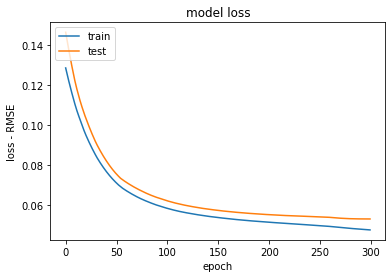

100/100 [==============================] - 0s 1ms/sample - loss: 0.0023 - val_loss: 0.0028


In [30]:
#CNN_2d.fit(X_train, Y_train, epochs = 300, batch_size =100, validation_data = (X_test, Y_test) , callbacks=[plot_losses])
CNN_2d.fit([X_train, mask_train], Y_train, batch_size=100, epochs = 300, validation_data = ([X_test, mask_test], Y_test), callbacks=[plot_losses])

** Learning rate:**

In [32]:
import keract
keract.get_activations(CNN_2d, X_train, layer_name='output', nodes_to_evaluate=None, output_format='full', auto_compile=True)

OrderedDict([('output_1/Identity:0',
              array([[[0.0221379 ],
                      [0.00207995],
                      [0.00875322],
                      ...,
                      [0.        ],
                      [0.        ],
                      [0.        ]],
              
                     [[0.02151055],
                      [0.00184543],
                      [0.00836741],
                      ...,
                      [0.        ],
                      [0.        ],
                      [0.        ]],
              
                     [[0.0208832 ],
                      [0.00161092],
                      [0.00798155],
                      ...,
                      [0.        ],
                      [0.        ],
                      [0.        ]],
              
                     ...,
              
                     [[0.00802867],
                      [0.        ],
                      [0.00111409],
                      ...,
          

In [33]:
from keract import get_activations
activations = get_activations(CNN_2d, X_train, auto_compile=True)
[print(k, '->', v.shape, '- Numpy array') for (k, v) in activations.items()]


input_2 -> (362, 15, 1) - Numpy array
conv0_1 -> (100, 362, 15, 10) - Numpy array
mul_4 -> (100, 362, 15, 10) - Numpy array
conv1_1 -> (100, 362, 15, 10) - Numpy array
mul_5 -> (100, 362, 15, 10) - Numpy array
conv2_1 -> (100, 362, 15, 10) - Numpy array
mul_6 -> (100, 362, 15, 10) - Numpy array
conv3_1 -> (100, 362, 15, 10) - Numpy array
mul_7 -> (100, 362, 15, 10) - Numpy array
conv4_1 -> (100, 362, 15, 1) - Numpy array
max_pooling2d_1 -> (100, 362, 1, 1) - Numpy array
output_1 -> (100, 362, 1) - Numpy array


[None, None, None, None, None, None, None, None, None, None, None, None]

In [34]:
array = activations['output_1']

In [35]:
array = np.squeeze(array, axis=2)

In [37]:
np.savetxt('output.csv', array, delimiter=',')   

In [298]:
keract.get_gradients_of_trainable_weights(CNN_2d, X_train, Y_test)

OrderedDict([('conv0_18/kernel:0',
              array([[[[-0.00211596,  0.00981923,  0.01729037, -0.00147642,
                         0.01438366,  0.00034494, -0.00270267, -0.00156842,
                        -0.00263556, -0.00229144]]],
              
              
                     [[[-0.00211704,  0.00976419,  0.01715731, -0.00146944,
                         0.0145193 ,  0.00023896, -0.00270749, -0.00156844,
                        -0.00265937, -0.00231092]]],
              
              
                     [[[-0.002119  ,  0.00985717,  0.01715673, -0.00146813,
                         0.01452821,  0.00030843, -0.00271896, -0.00157244,
                        -0.0026727 , -0.00239944]]],
              
              
                     [[[-0.00213238,  0.00989408,  0.01717214, -0.0014758 ,
                         0.01457066,  0.00023635, -0.0027227 , -0.00162603,
                        -0.00265847, -0.00240822]]],
              
              
                     [[[-

In [299]:
keract.get_gradients_of_activations(CNN_2d, X_train, Y_test, layer_name='output', output_format='numbered')

OrderedDict([('output_12/Identity:0',
              array([[[0.0000000e+00],
                      [2.8050483e-05],
                      [2.7873017e-05],
                      ...,
                      [0.0000000e+00],
                      [0.0000000e+00],
                      [0.0000000e+00]],
              
                     [[0.0000000e+00],
                      [2.8022416e-05],
                      [2.7872997e-05],
                      ...,
                      [0.0000000e+00],
                      [0.0000000e+00],
                      [0.0000000e+00]],
              
                     [[0.0000000e+00],
                      [2.7994402e-05],
                      [2.7872973e-05],
                      ...,
                      [0.0000000e+00],
                      [0.0000000e+00],
                      [0.0000000e+00]],
              
                     ...,
              
                     [[0.0000000e+00],
                      [0.0000000e+00],
            

Save the model (architecture, weights, ...) 

In [300]:
CNN_2d.save('5-layer-CNN.h5') 

In [374]:
for layer in CNN_2d.layers: print(layer.get_config(), layer.get_weights())

{'batch_input_shape': (None, 362, 14, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_31'} []
{'name': 'masking_31', 'trainable': True, 'batch_input_shape': (None, 362, 14, 1), 'dtype': 'float32', 'mask_value': 0.0} []
{'name': 'conv0', 'trainable': True, 'dtype': 'float32', 'filters': 10, 'kernel_size': (10, 1), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': 0}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[[[-0.13063328,  0.09547539,  0.1322246 ,  0.13599437,
          -0.06026269,  0.16776747,  0.13627695, -0.13404614,
           0.17376825,  0.00482216]]],


       [[[-0.16563325, -0.18208396,  0.10748444, -0.13185161,
          -0.07473969,  0.00425589, -0.04

In [303]:
def score_cal(y_pred, Y_test):
    d   = y_pred - Y_test
    tmp = np.zeros(d.shape[0])
    for i in range(d.shape[0]):
        if d[i,0] >= 0:
           tmp[i] = np.exp( d[i,0]/10) - 1
        else:
           tmp[i] = np.exp(-d[i,0]/13) - 1
    return tmp 

In [304]:
first_layer_weights = CNN_2d.layers[1].get_weights()
#first_layer_biases  = CNN_2d.layers[1].get_weights()[1]
#second_layer_weights = CNN_2d.layers[1].get_weights()[0]
#last_layer_biases  = CNN_2d.layers[1].get_weights()[1]
last_layer_weights = CNN_2d.layers[10].get_weights()

In [305]:
print(last_layer_weights)

[]


In [306]:
#prediction = model.predict(np.array(tk.texts_to_sequences(text)))
predictions = CNN_2d.predict(np.array(X_test))
print('predictions shape:', predictions.shape)

InvalidArgumentError:  Incompatible shapes: [32,10,362,15] vs. [100,1,362,1]
	 [[node CNN_2d/tf_op_layer_mul_52/mul_52 (defined at C:\Users\Nollmann\Anaconda3\envs\tf-gpu1\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_distributed_function_38965]

Function call stack:
distributed_function


Another popular metric to evaluate the effectiveness of the proposed method is Root Mean Square Error (RMSE).

## 4.2 Training set

In [85]:
preds = CNN_2d.evaluate(x = X_train, y = Y_train)
print()
print ("Test  MSE = " + str(preds))
print ("Test RMSE = " + str(np.sqrt(preds)))

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: Incompatible shapes: [32,10,362,14] vs. [100,1,362,1]
	 [[{{node multiply_30/mul}}]]
  (1) Invalid argument: Incompatible shapes: [32,10,362,14] vs. [100,1,362,1]
	 [[{{node multiply_30/mul}}]]
	 [[loss_2/mul/_469]]
0 successful operations.
0 derived errors ignored.

In [86]:
y_hat_tr   = CNN_2d.predict(x = X_train)
score_i_tr = score_cal(y_hat_tr, Y_train)
score_tr   = print("Score = " + str(sum(score_i_tr)))

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: Incompatible shapes: [32,10,362,14] vs. [100,1,362,1]
	 [[{{node multiply_30/mul}}]]
  (1) Invalid argument: Incompatible shapes: [32,10,362,14] vs. [100,1,362,1]
	 [[{{node multiply_30/mul}}]]
	 [[RUL_5/BiasAdd/_479]]
0 successful operations.
0 derived errors ignored.

### 4.2.1 Plots

In [307]:
d_tr = y_hat_tr - Y_train
plt.hist(d_tr, bins='auto')  
plt.title('Error distribution - Training Set')
plt.ylabel('f')
plt.xlabel("Error: $RUL_{hat}$ - RUL")
plt.show()

NameError: name 'y_hat_tr' is not defined

## 4.3 Test set

In [81]:
y_hat   = CNN_2d.predict(x = X_test)
score_i = score_cal(y_hat, Y_test)
score   = print("Score = " + str(sum(score_i)))

Score = 220.43856270820186


In [82]:
preds = CNN_2d.evaluate(x = X_test, y = Y_test)
print()
print ("MSE = " + str(preds))
print ("RMSE = " + str(np.sqrt(preds)))

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### 4.3.1 Plots

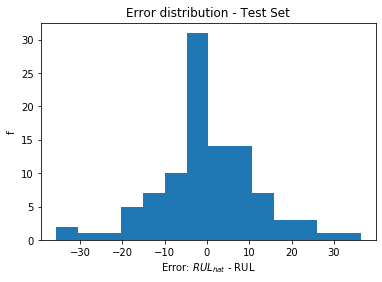

In [83]:
d = y_hat - Y_test
plt.hist(d, bins='auto')  
plt.title('Error distribution - Test Set')
plt.ylabel('f')
plt.xlabel("Error: $RUL_{hat}$ - RUL")
plt.show()

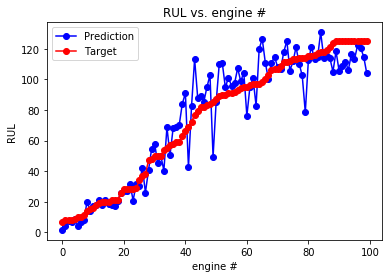

In [84]:
x     = range(0,100)
y_ts  = np.sort(Y_test[:,0])
idx   = np.argsort(Y_test[:,0])
y_tr  = y_hat[idx,0]
plt.plot(x, y_tr, 'bo-', x, y_ts, 'ro-')
plt.title('RUL vs. engine #')
plt.ylabel('RUL')
plt.xlabel('engine #')
plt.legend(['Prediction', 'Target'], loc='upper left')
plt.show()

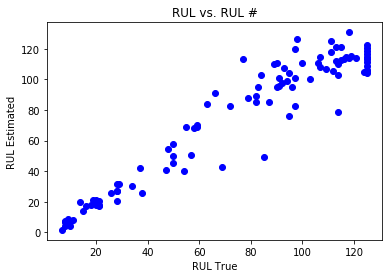

In [85]:
plt.plot(Y_test, y_hat, 'bo')
plt.title('RUL vs. RUL #')
plt.ylabel('RUL Estimated')
plt.xlabel('RUL True')
plt.show()

# 5 Conclusions

In [86]:
Y_test[Y_test > R_early] = R_early                     # R_early = 125 
preds = CNN_2d.evaluate(x = X_test, y = Y_test)
print()
print ("MSE = " + str(preds))
print ("RMSE = " + str(np.sqrt(preds)))

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

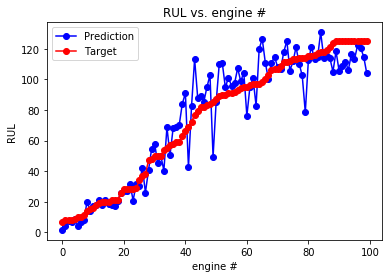

In [87]:
x     = range(0,100)
y_ts  = np.sort(Y_test[:,0])
idx   = np.argsort(Y_test[:,0])
y_tr  = y_hat[idx,0]
plt.plot(x, y_tr, 'bo-', x, y_ts, 'ro-')
plt.title('RUL vs. engine #')
plt.ylabel('RUL')
plt.xlabel('engine #')
plt.legend(['Prediction', 'Target'], loc='upper left')
plt.show()

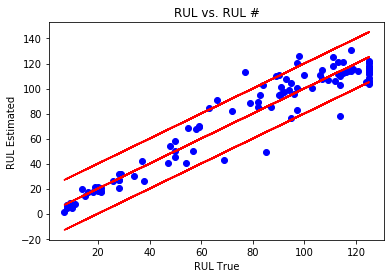

In [88]:
plt.plot(Y_test, y_hat, 'bo')
plt.plot(Y_test,Y_test, 'r-')
plt.plot(Y_test,Y_test+20, 'r--')
plt.plot(Y_test,Y_test-20, 'r--')
plt.title('RUL vs. RUL #')
plt.ylabel('RUL Estimated')
plt.xlabel('RUL True')
plt.show()